# Face detection explorations  

**This notebook explores face-recoginition using the OpenCV2 framework**

*IMPORTANT NOTE* - the base `environment.yml` does not include installation of OpenCV2, since it is an optional branch in this project. In order to get the build including OpenCV refer to with `/adv-envs/environment-ocv.yml`.  

## Using OpenCV  

Let's start by importing OpenCV and reading some images. Don't worry, we'll soon get to the goodies (face-detection).

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import cv2

import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Import our tools
import sys
sys.path.append('/Users/will/Github/facial-keypoint-detection/scripts')

# Import submit module from our tools subfolder
from tools import getdata

Read our data (this time we don't need test data)

In [2]:
# Load data (no dev)
_loaded = getdata.load_data(0, test=False, nonas=False)

FEATURES = _loaded['features']
print 'Number of features:', len(FEATURES)

train_data = _loaded['training']['data']
train_labels = _loaded['training']['labels']
print 'Training dataset size: ', train_data.shape

Number of features: 30
Training dataset size:  (7049,)


Let's plot a couple images...

In [3]:
def plot_faces(faces):
    ''' Plots a bunch of faces '''
    fig, axes = plt.subplots(1,len(faces), figsize=(18,4))
    for i,face in enumerate(faces):
        axes[i].imshow(train_data[face].reshape(96,96), cmap=plt.cm.gray)
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

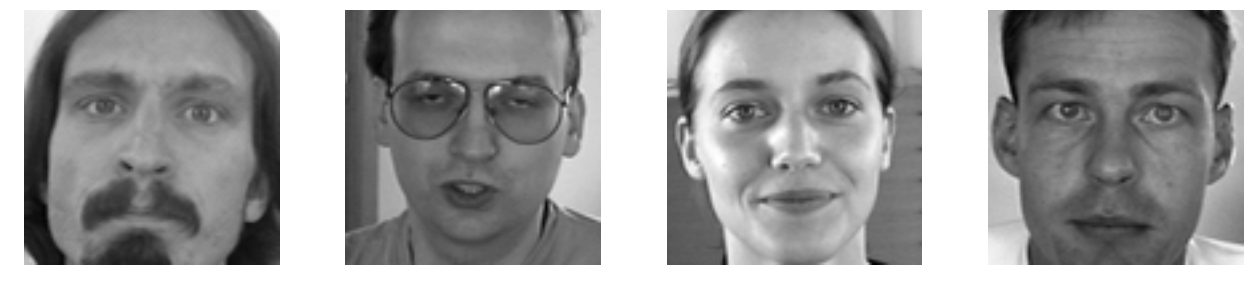

In [37]:
plot_faces([0, 13, 9, 44])

## Non-standard images
Let's find some "weird" pictures, for that we will select max and min values in `nose_center` or missing features

In [58]:
def get_weird(feature, verbose=True):
    ''' Finds the pictures with max / min feature x & y '''
    _max = np.argmax(train_labels[:,feature])
    _min = np.argmin(train_labels[:,feature])
    if verbose:
        print "Weird {f:<20} MAX: {mx}\t MIN: {mn}".format(
            f=FEATURES[feature], mx=_max , mn=_min)
    return [_max, _min]

In [59]:
weird_img = set()
for i in [2,3, 20,21, 22,23]:
    new_weird = get_weird(i)
    weird_img.update(new_weird)

print "\nWEIRD IMAGES:", list(weird_img)

Weird right_eye_center_x   MAX: 1620	 MIN: 1620
Weird right_eye_center_y   MAX: 1620	 MIN: 1620
Weird nose_tip_x           MAX: 2175	 MIN: 1907
Weird nose_tip_y           MAX: 2453	 MIN: 3510
Weird mouth_left_corner_x  MAX: 1620	 MIN: 1620
Weird mouth_left_corner_y  MAX: 1620	 MIN: 1620

WEIRD IMAGES: [1907, 1620, 2453, 3510, 2175]


Let's plot these out

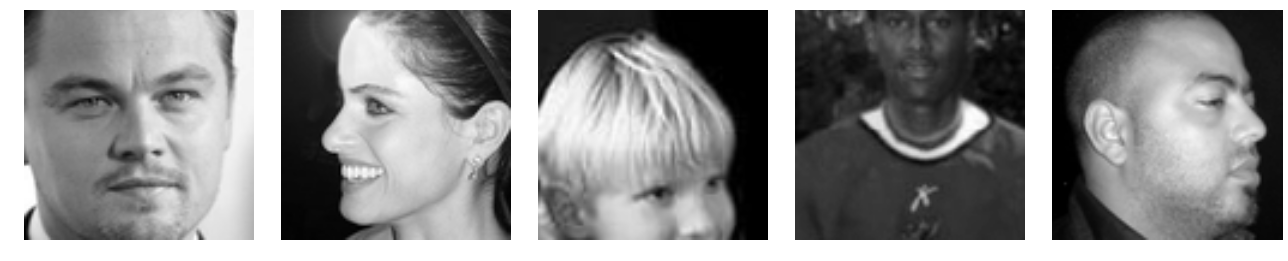

In [42]:
plot_faces(weird_img)

What is DiCaprio doing there?!  

Anyway, the rest of the images are definitely "non-standard". Let's concentrate on these two:

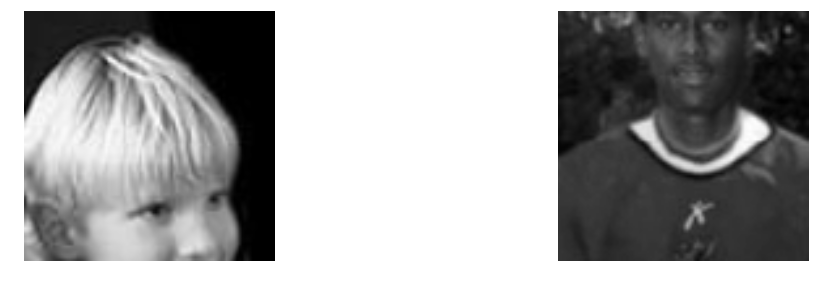

In [43]:
plot_faces([2453, 3510])

## Face Detection  
Let's use OpenCV's face detection on these standard images.  

OpenCV's comes with a trained Haar Classifier that implements the [Viola-Jones algorithm](https://en.wikipedia.org/wiki/Viola%E2%80%93Jones_object_detection_framework). Refer to the [original paper](http://citeseerx.ist.psu.edu/viewdoc/download;jsessionid=585C7246498233B7C16892BBE094144C?doi=10.1.1.10.6807&rep=rep1&type=pdf) for more detail on the cascade-boosting approach.

In [149]:
CASC_PATH = '../haarcascade_frontalface_default.xml'

# Create the haar cascade classifier
faceCascade = cv2.CascadeClassifier(CASC_PATH)

def detect_face(img, min_face_size):
    ''' Detect faces in the image'''
    face = faceCascade.detectMultiScale(
        img,
        scaleFactor=1.1,
        minNeighbors=5,
        minSize=(min_face_size, min_face_size),
        flags = cv2.cv.CV_HAAR_SCALE_IMAGE)
    return face

In [90]:
def plot_face_detect(faces, min_face_size=10):
    ''' Plots a bunch of faces '''
    fig, axes = plt.subplots(1,len(faces), figsize=(18,4))
    
    for i,face in enumerate(faces):
        img = train_data[face].reshape(96,96)

        # Detect faces
        face = detect_face(img, min_face_size)

        # Plot image and rectangle on the face detected
        axes[i].imshow(img, cmap=plt.cm.gray)
        axes[i].axis('off')
        for (x,y,w,h) in face:
            _rect = patches.Rectangle( (x,y), w, h, fill=False, color='orange', lw=3)
            axes[i].add_patch(_rect)
    
    plt.tight_layout()
    plt.show()

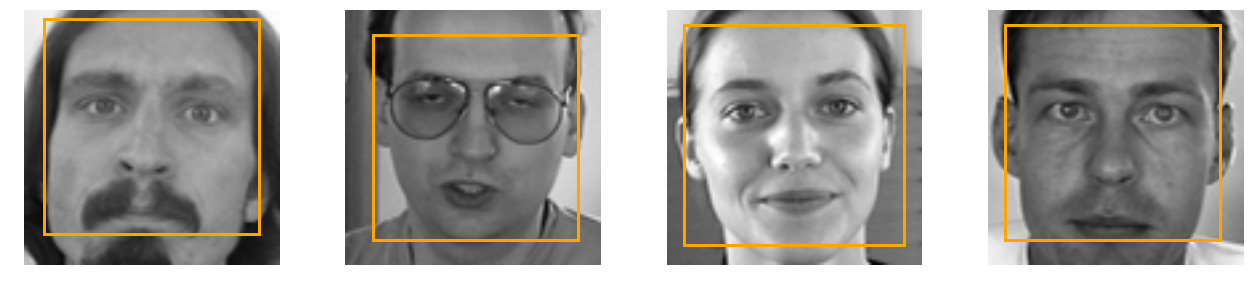

In [91]:
plot_face_detect([0, 13, 9, 44])

Now let's try it out on those non-standard images.  

*Disclaimer - this approach may not work on all non-standard images since the classifier is trained to work for full-frontal faces. However, let's give it a try*

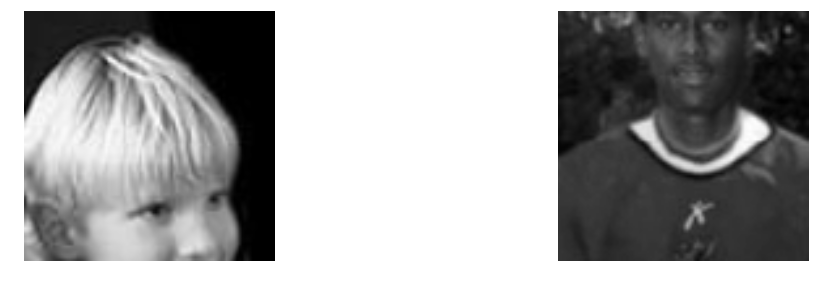

In [94]:
plot_face_detect([2453, 3510], min_face_size=5)

Our classifier is not able to detect the faces...!  

Let's try with all the weird images detected from all features.

In [95]:
all_weird_img = set()
for i in xrange(len(FEATURES)):
    new_weird = get_weird(i, verbose=False)
    all_weird_img.update(new_weird)

print "WEIRD IMAGES:", list(all_weird_img)

WEIRD IMAGES: [1601, 1636, 3510, 1703, 1585, 210, 1907, 1620, 2453, 1654, 1687, 1724, 2175]


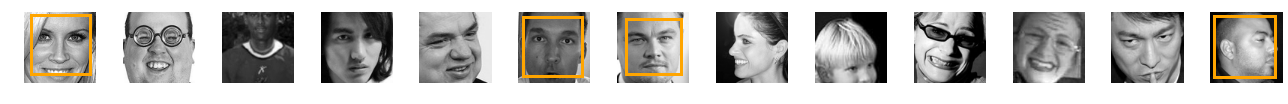

In [96]:
plot_face_detect(all_weird_img)

It seems we are not getting really "non-standard" images with this approach.

### More non-standard images

Let us concentrate only on the weird images by nose's x & y, and mouth y. But let's get more weird images than just the max and min.


In [68]:
def get_more_weird(feature, n=5, verbose=True):
    ''' Finds the pictures with max / min feature x & y '''
    _weird = []
    _weird.extend( train_labels[:,feature].argsort()[-1*n:] )
    _weird.extend( train_labels[:,feature].argsort()[:n] )
    if verbose:
        print "Weird {f:<20} Images: {ims}".format(f=FEATURES[feature], ims=_weird)
    return _weird

In [77]:
mo_weird = set()
for i in [20,21,23]:
    new_weird = get_more_weird(i, n=4)
    mo_weird.update(new_weird)

mo_weird = list(mo_weird)

print "\nWEIRD IMAGES:", mo_weird

Weird nose_tip_x           Images: [2199, 6493, 2175, 4263, 1907, 6315, 1652, 1620]
Weird nose_tip_y           Images: [2289, 1877, 3447, 2453, 3510, 6765, 5117, 6782]
Weird mouth_left_corner_y  Images: [3858, 3857, 3855, 7048, 1635, 2036, 2054, 2151]

WEIRD IMAGES: [2054, 7048, 3855, 3857, 3858, 2453, 2199, 4263, 6315, 3510, 1652, 1620, 1877, 6493, 1635, 2151, 6765, 2289, 1907, 2036, 3447, 5117, 6782, 2175]


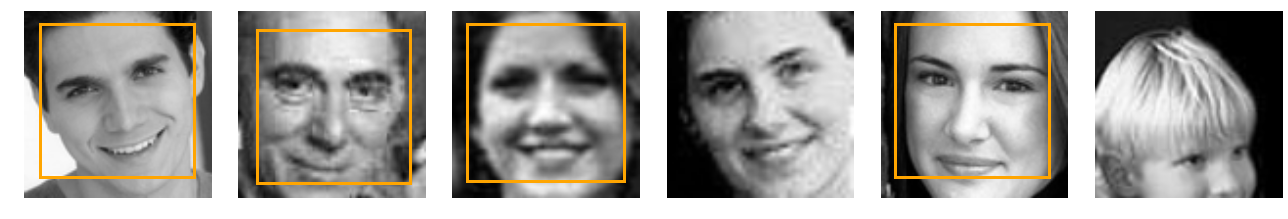

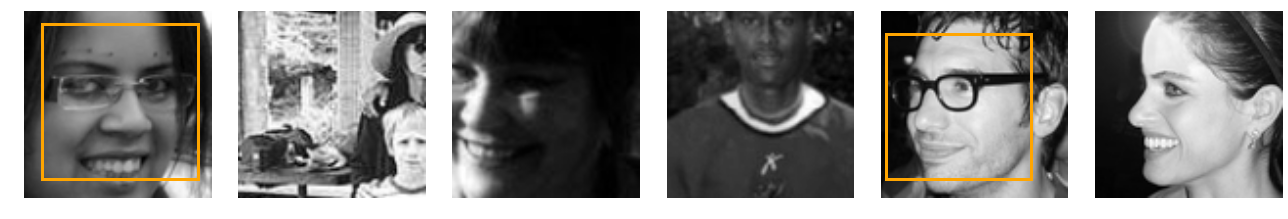

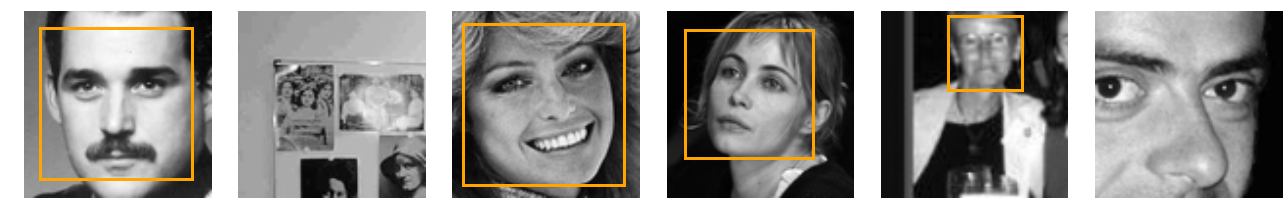

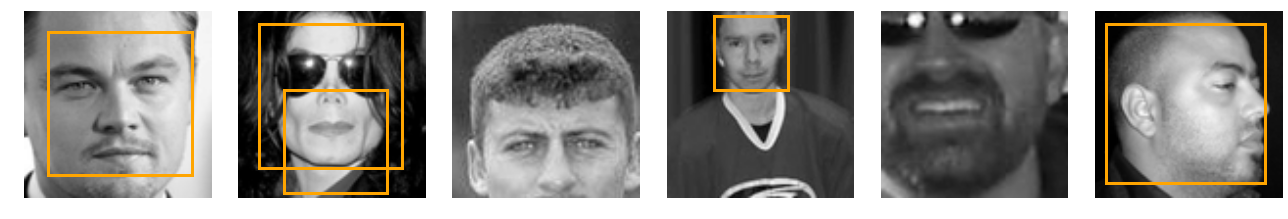

In [98]:
# Plot the faces in rows
plot_face_detect(mo_weird[:6])
plot_face_detect(mo_weird[6:12], min_face_size=5)
plot_face_detect(mo_weird[12:18], min_face_size=5)
plot_face_detect(mo_weird[18:])

Oh, there are some interesting cases in there:

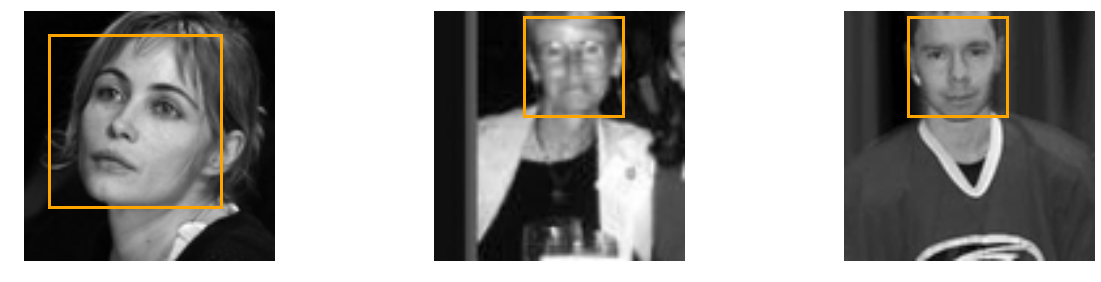

In [85]:
the_weird_ones = [mo_weird[15], mo_weird[16], mo_weird[21]]

plot_face_detect(the_weird_ones)

## Noise reduction - Cropping the faces

Now we want to make the models concentrate on only the faces detected and disregard all other areas.

We could zoom in the face (crop out all the rest), however that would create images of different sizes and this would bring some problems when modeling images of different sizes.  

Let us just **mask the image** (set all pixels outside the detected face to 0).

In [150]:
def mask_faces(faces):
    ''' Masked faces detected '''
    masked = []
    
    for i,_face in enumerate(faces):
        old_img = train_data[_face].reshape(96,96)
        
        # detect face
        _face = detect_face(old_img, min_face_size=10)
                
        # only crop if we detect one face
        if len(_face) == 1:
            x, y, w, h = _face[0]
            new_img = np.zeros_like(old_img)
            new_img[y:y+h, x:x+w] = old_img[y:y+h, x:x+w]
            
            masked.append(new_img.flatten())
            
        else:
            masked.append(old_img.flatten())
        
    return masked

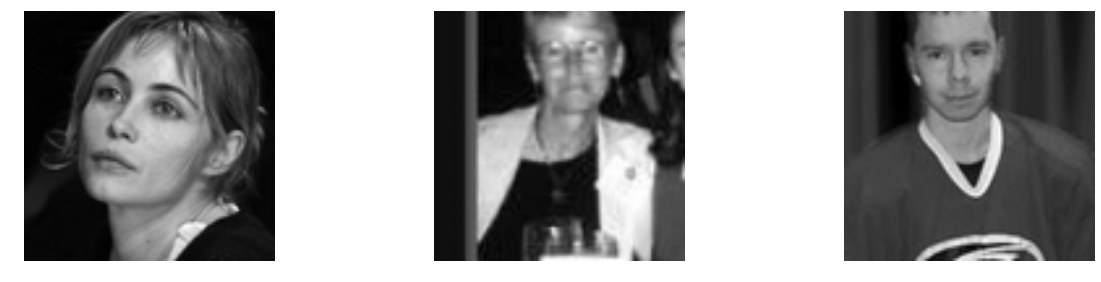

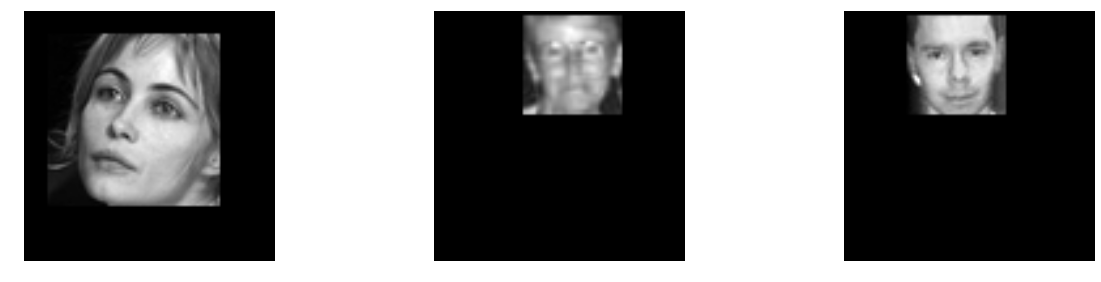

In [151]:
# Plot originals
plot_faces(the_weird_ones)

# Mask
faces_masked = mask_faces(the_weird_ones)

# Plot masked
fig, axes = plt.subplots(1,3, figsize=(18,4))
for i, fac in enumerate(faces_masked):
    axes[i].imshow(fac.reshape(96,96), cmap=plt.cm.gray)
    axes[i].axis('off')
fig.tight_layout()
plt.show()

**Great, now that we got it working we will create a script called `preprocessors/face_masker.py` that will allow us to mask all the faces and save the masked faces into `data/preprods/`.**